In [51]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import json
import copy
from collections import defaultdict
import pickle
import torch
import matplotlib.pyplot as plt
import neural_renderer as nr
from adversarial_objects.modules import wavefront, combiner
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
edited_shapenet_json = defaultdict(list)

In [46]:
TEXTURE_SIZE = 4
adv_obj = wavefront.load_obj(
    'cube',
    texture_size=TEXTURE_SIZE,
    adv_tex=True,
    adv_ver=True,
    rng_tex=True,
)
nobj = 1

In [47]:
shapenet_json_file = 'adversarial_objects/data/shapenet_model_list.json'
with open(shapenet_json_file, 'r') as f:
    shapenet_json = json.load(f)

len(shapenet_json)
# TODO: Change this
todo_keys = sorted([k for k, _ in shapenet_json.items()])
renderer = nr.Renderer(camera_mode='look_at', image_size=299)

Doing shapenet.bag.0


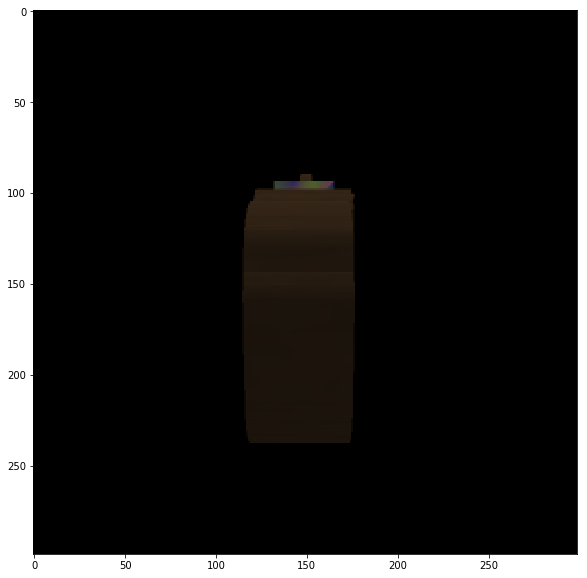

In [59]:
doing = 0
good = False
print('Doing {}'.format(todo_keys[doing]))
original_model_info = shapenet_json[todo_keys[doing]]
editing_model_info = copy.deepcopy(original_model_info)

editing_model_info['translation_param_init'] = {
            'group': [0.0, 0.0, 0.0],
            'random_multiplier': [0.02, 0.02, 0.02],
            'circle_radius': [0.0, 0.4, 0.4],
}
editing_model_info['scaling_param_init'] = {
    'multiplier': [0.15, 0.15, 0.15],
}
editing_model_info['rotation_param_init'] = {
    'absolute': [0.0, 0.0, 0.0],
}

editing_model_info['rendering'] = {
    'camera_distance': 2.72,
    'elevation': 5.0,
    'azimuth': 90.0,
}

editing_model_info['base_object_init'] = {
    # Translate first then scale.
    'translation': [0.0, 0.0, 0.0],
    'scale': 1.0,
}

# TODO: Visualize and edit and stuff
with torch.no_grad():
    bv, bf, bt = nr.load_obj(editing_model_info['wavefront_file'], load_texture=True, texture_size=TEXTURE_SIZE)
    bv -= torch.tensor(editing_model_info['base_object_init']['translation'], device='cuda')
    bv /= editing_model_info['base_object_init']['scale']
    obj_vft = (bv.unsqueeze(0), bf.unsqueeze(0), bt.unsqueeze(0))

    adv_translation = torch.tensor(editing_model_info['translation_param_init']['group'], device='cuda')
    adv_translation += torch.tensor(editing_model_info['translation_param_init']['random_multiplier'], device="cuda") \
        * torch.randn((3, ), device='cuda')
    adv_translation += torch.tensor([
            0.0,
            editing_model_info['translation_param_init']['circle_radius'][1] * np.cos(2 * np.pi * 1 / nobj),
            editing_model_info['translation_param_init']['circle_radius'][1] * np.sin(2 * np.pi * 1 / nobj)
        ], dtype=torch.float, device='cuda')

    adv_scaling = torch.tensor(editing_model_info['scaling_param_init']['multiplier'], device='cuda')
    adv_rotation = torch.tensor(editing_model_info['rotation_param_init']['absolute'], device='cuda')
    adv_vfts = [adv_obj.render_parameters(
        affine_transform=wavefront.create_affine_transform(
            adv_scaling,
            adv_translation,
            adv_rotation,
            True,
        ))]
    
    vft = combiner.combine_objects(
        *([[obj_vft[i]] + [adv_vft[i] for adv_vft in adv_vfts] for i in range(3)])
    )
    renderer.eye = nr.get_points_from_angles(
        editing_model_info['rendering']['camera_distance'], 
        editing_model_info['rendering']['elevation'], 
        editing_model_info['rendering']['azimuth'])
    
    img = renderer(*vft)
    npimg = img.cpu()[0].numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

if good:
    edited_shapenet_json[todo_keys[doing]].append(editing_model_info)
    with open('edited_shapenet_json.pkl', 'wb') as f:
        pickle.dump(edited_shapenet_json, f)

In [17]:
with open('edited_shapenet_json.pkl', 'rb') as f:
    print(pickle.load(f))

defaultdict(<class 'list'>, {'shapenet.bag.0': [{'translation_param_init': {'group': [0.0, 0.0, 0.0], 'relative': [0.0, 1.0, 1.0]}, 'synsetId': '02773838', 'wavefront_file': 'adversarial_objects/data/shapenetcore/ShapeNetCore.v2/02773838/10a885f5971d9d4ce858db1dc3499392/models/model_normalized.obj', 'children': ['03986949'], 'model_folder_name': '10a885f5971d9d4ce858db1dc3499392', 'numInstances': 83, 'base_object_init': {'translation': [0.0, 0.0, 0.0], 'order': '', 'scale': 1.0}, 'name': 'bag,traveling bag,travelling bag,grip,suitcase', 'rendering': {'camera_distance': 2.72, 'elevation': 5.0, 'azimuth': 90.0}}]})


In [43]:
shapenet_json['shapenet.bag.0']

{'model_folder_name': '10a885f5971d9d4ce858db1dc3499392',
 'numInstances': 83,
 'synsetId': '02773838',
 'rendering': {'elevation': 5.0, 'azimuth': 90.0, 'camera_distance': 2.72},
 'translation_param_init': {'relative': [0.0, 1.0, 1.0],
  'group': [0.0, 0.0, 0.0]},
 'children': ['03986949'],
 'name': 'bag,traveling bag,travelling bag,grip,suitcase',
 'base_object_init': {'order': '',
  'translation': [0.0, 0.0, 0.0],
  'scale': 1.0},
 'wavefront_file': 'adversarial_objects/data/shapenetcore/ShapeNetCore.v2/02773838/10a885f5971d9d4ce858db1dc3499392/models/model_normalized.obj'}